In [45]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from openai import OpenAI as oai
import ast
from openai import AzureOpenAI
import os
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import SequentialChain
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
import matplotlib.pyplot as plt
import math
import pingouin as pg
import re
import pickle

In [46]:
# Class to initialize Azure model
class mOpenAI:
    def __init__(self):
        self.client = AzureOpenAI(
            api_key="Add your API key",
            api_version="Add your API version",
            azure_endpoint="Add your API end-point"
        )
        self.deployment_name = 'Add your deployment name'

In [47]:
# Reading responses on scales
drive_base = "../"
pss = pd.read_csv(drive_base + "StudentLife/PerceivedStressScale.csv")
phq = pd.read_csv(drive_base + "StudentLife/PHQ-9.csv")
loneliness = pd.read_csv(drive_base + "StudentLife/LonelinessScale.csv")
flourishing = pd.read_csv(drive_base + "StudentLife/FlourishingScale.csv")

In [48]:
loneliness_questions = loneliness.columns[2:]

In [49]:
flourishing_questions = list(flourishing.columns[2:])

In [50]:
loneliness_questions = [' '.join(l.split(" ")[1:]) for l in loneliness_questions]


In [51]:
phq_questions = list(phq.columns[2: -1])
pss_questions = pss.columns[2:]
pss_questions = [' '.join(l.split(" ")[1:]) for l in pss_questions]


In [52]:
pss_questions

['In the last month, how often have you been upset because of something that happened unexpectedly?',
 'In the last month, how often have you felt that you were unable to control the important things in your life?',
 'In the last month, how often have you felt nervous and "stressed"?',
 'In the last month, how often have you felt confident about your ability to handle your personal problems?',
 'In the last month, how often have you felt that things were going your way?',
 'In the last month, how often have you found that you could not cope with all the things that you had to do?',
 'In the last month, how often have you been able to control irritations in your life?',
 'In the last month, how often have you felt that you were on top of things?',
 'In the last month, how often have you been angered because of things that were outside of your control?',
 'In the last month, how often have you felt difficulties were piling up so high that you could not overcome them?']

In [11]:
pss_questions

['In the last month, how often have you been upset because of something that happened unexpectedly?',
 'In the last month, how often have you felt that you were unable to control the important things in your life?',
 'In the last month, how often have you felt nervous and "stressed"?',
 'In the last month, how often have you felt confident about your ability to handle your personal problems?',
 'In the last month, how often have you felt that things were going your way?',
 'In the last month, how often have you found that you could not cope with all the things that you had to do?',
 'In the last month, how often have you been able to control irritations in your life?',
 'In the last month, how often have you felt that you were on top of things?',
 'In the last month, how often have you been angered because of things that were outside of your control?',
 'In the last month, how often have you felt difficulties were piling up so high that you could not overcome them?']

In [12]:
loneliness_questions

['I feel in tune with the people around me',
 'I lack companionship',
 'There is no one I can turn to',
 'I do not feel alone',
 'I feel part of a group of friends',
 'I have a lot in common with the people around me',
 'I am no longer close to anyone',
 'My interests and ideas are not shared by those around me',
 'I am an outgoing person',
 'There are people I feel close to',
 'I feel left out',
 'My social relationships are superficial',
 'No one really knows me well',
 'I feel isolated from others',
 'I can find companionship when I want it',
 'There are people who really understand me',
 'I am unhappy being so withdrawn',
 'People are around me but not with me',
 'There are people I can talk to',
 'There are people I can turn to']

In [13]:
phq_questions

['Little interest or pleasure in doing things',
 'Feeling down, depressed, hopeless.',
 'Trouble falling or staying asleep, or sleeping too much.',
 'Feeling tired or having little energy',
 'Poor appetite or overeating',
 'Feeling bad about yourself or that you are a failure or have let yourself or your family down',
 'Trouble concentrating on things, such as reading the newspaper or watching television',
 'Moving or speaking so slowly that other people could have noticed. Or the opposite being so figety or restless that you have been moving around a lot more than usual',
 'Thoughts that you would be better off dead, or of hurting yourself']

In [15]:
# Function to calculates aggregated loneliness scores
def calculate_loneliness_score(answers):
    assert (len(answers) == 20)
    reversed_scores = [4 - ans if i+1 in [1, 4, 5, 6, 9, 10, 15, 16, 19, 20] else ans for i, ans in enumerate(answers)]
    # Calculate total score
    total_score = sum(reversed_scores)
    return total_score

In [16]:
# Function to calculates aggregated PSS score
def calculate_pss_score(answers):
    assert (len(answers) == 10)
    reversed_scores = [4 - ans if i in [3, 4, 6, 7] else ans for i, ans in enumerate(answers)]
    # Calculate total score
    total_score = sum(reversed_scores)

    return total_score

In [17]:
pss_scale = {
    "Never": 0,
    "Almost never": 1,
    "Sometimes": 2,
    "Sometime": 2,
    "Fairly often": 3,
    "Very often": 4,
     np.nan: 2
}

phq_scale = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}

loneliness_scale = {
    "Often": 4,
    "Sometimes": 3,
    "Rarely": 2,
    "Never": 1
}

flourishing_scale = {
    "Strongly disagree": 1,
    "Disagree": 2,
    "Slightly disagree": 3,
    "Mixed or neither agree nor disagree": 4,
    "Slightly agree": 5,
    "Agree": 6,
    "Strongly agree": 7
}

In [18]:
# Saving real responses to scale in a dict
responses_dict = {}
for i, row in phq.iterrows():
    phq_responses = row.values.tolist()[2:-1]
    pss_row = pss[(pss['uid'] == row['uid']) & (pss['type'] == row['type'])]
    loneliness_row = loneliness[(loneliness['uid'] == row['uid']) & (loneliness['type'] == row['type'])]
    flourishing_row = flourishing[(flourishing['uid'] == row['uid']) & (flourishing['type'] == row['type'])]
    if(pss_row.empty or loneliness_row.empty or flourishing_row.empty):
        continue
    pss_responses  = pss_row.values.tolist()[0][2:]
    loneliness_responses  = loneliness_row.values.tolist()[0][2:]
    flourishing_responses = flourishing_row.values.tolist()[0][2:]

    pss_response_num = [pss_scale[p] for p in pss_responses]
    phq_response_num = [phq_scale[p] for p in phq_responses]
    loneliness_responses = [loneliness_scale[p] for p in loneliness_responses]
    flourishing_responses = [int(p) if not math.isnan(p) else 4 for p in flourishing_responses]
    responses_dict[(row['uid'], row['type'])] = {"phq": phq_response_num, "pss": pss_response_num, "loneliness":loneliness_responses, "flourishing": flourishing_responses }

In [19]:
# Uncomment to save responses dict
#  with open(drive_base + f"outputs/studentLife-original-responses", 'wb') as file:
#       pickle.dump(responses_dict, file)

### Configuration

In [44]:
# Configuration to run the model
api_to_use = "Azure" # Options: "Azure" and "OpenAI"
prompting_method = "direct" # Options: "direct" and "chain_of_thought"
# change these for different scale: pss, phq, loneliness, flourishing
scale_given = "pss"
scale_generated = "phq"
rerun = False # False: load from disk and True: rerun GPT model

In [21]:
# Function to get aggregated scores for scales
def get_scores_responses(responses, scale):
    if scale == "pss":
        return calculate_pss_score(responses)
    elif scale == "loneliness":
        return calculate_loneliness_score(responses)
    else:
        return sum(responses)


In [23]:
# correlation between real responses on scales
scale_given_scores = [get_scores_responses(responses_dict[r][scale_given], scale_given) for r in responses_dict]
scale_generated_scores = [get_scores_responses(responses_dict[r][scale_generated], scale_generated) for r in responses_dict]

corr_coeff, p_value = pearsonr(scale_given_scores, scale_generated_scores)
print(f"Pearson correlation coefficient {scale_given} and {scale_generated} (real):", corr_coeff)
print("p-value:", p_value)

corr_coeff, p_value = spearmanr(scale_given_scores, scale_generated_scores)
print(f"Spearman correlation coefficient {scale_given} and {scale_generated} (real):", corr_coeff)
print("p-value:", p_value)

Pearson correlation coefficient pss and phq (real): 0.6231417416777991
p-value: 6.707834731009549e-10
Spearman correlation coefficient pss and phq (real): 0.5299244775723991
p-value: 4.305239570624242e-07


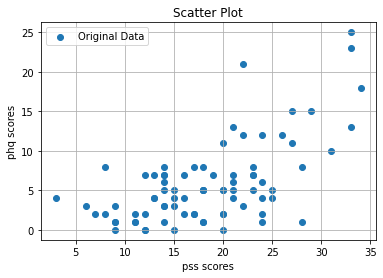

In [25]:
# plotting the scatter plots distribution of scales
import numpy as np
import matplotlib.pyplot as plt

data = list(zip(scale_given_scores, scale_generated_scores))
x_data = np.array([point[0] for point in data])
y_data = np.array([point[1] for point in data])

plt.scatter(x_data, y_data, label='Original Data')
plt.xlabel(scale_given + ' scores')
plt.ylabel(scale_generated + ' scores')
plt.title('Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#prompts for different scales

In [26]:
phq_dict = {
    "questions": phq_questions,
    "asking_prompt": "score the given PHQ scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements, score them one by one:",
    "asking_prompt_demo": "score the given PHQ scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Make sure to use demographic information too. Here are the statements, score them one by one:",

    "asking_prompt_chain": "score the given PHQ scale questions as the person 'X' would have from 0 to 3 (inclusive). 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements, think step by step and score one by one",
    "providing_prompt": "Suppose person 'X' answered these PHQ scale questions from 0 to 3 where 0 denotes 'Not at all', 1 denotes 'Several days', 2 denotes 'more than half days', 3 denotes 'nearly everyday'. Here are the statements:"
}

In [27]:
pss_dict = {
    "questions": pss_questions,
    "asking_prompt": "score the given PSS scale questions as person 'X' would have from 0 to 4 (inclusive). 0 denotes 'Never', 1 denotes 'Almost never', 2 denotes 'Sometimes', 3 denotes 'Fairly often', and 4 denotes 'Very often'. Here are the statements, score them one by one:",
    "asking_prompt_chain": "score the given PSS scale questions as person 'X' would have from 0 to 4 (inclusive). 0 denotes 'Never', 1 denotes 'Almost never', 2 denotes 'Sometimes', 3 denotes 'Fairly often', and 4 denotes 'Very often'. Here are the statements, think and score them one by one:",

    "providing_prompt": "Suppose person 'X' answered these PSS scale questions from 0 to 4 where 0 denotes 'Never', 1 denotes 'Almost never', 2 denotes 'Sometimes', 3 denotes 'Fairly often', and 4 denotes 'Very often'. Here are the statements:"
}

In [28]:
loneliness_dict = {
    "questions": loneliness_questions,
    "asking_prompt": "score the given Loneliness scale questions as person 'X' would have from 1 to 4 (inclusive). 1 denotes 'Never', 2 denotes 'Rarely', 3 denotes 'Sometimes', and 4 denotes 'Often'. Here are the statements, score them one by one:",
    "asking_prompt_chain": "score the given Loneliness scale questions as person 'X' would have from 1 to 4 (inclusive). 1 denotes 'Never', 2 denotes 'Rarely', 3 denotes 'Sometimes', and 4 denotes 'Often'. Here are the statements, think and score them one by one:",

    "providing_prompt": "Suppose person 'X' answered these Loneliness scale questions from 1 to 4 where 1 denotes 'Never', 2 denotes 'Rarely', 3 denotes 'Sometimes', and 4 denotes 'Often'. Here are the statements:"
}

In [29]:
flourishing_dict = {
    "questions": flourishing_questions,
    "asking_prompt": "score the given Flourishing scale questions as person 'X' would have from 1 to 7 (inclusive). 1 denotes 'Strongly disagree', 2 denotes 'Disagree', 3 denotes 'Slightly disagree', 4 denotes 'Mixed or neither agree nor disagree', 5 denotes 'Slightly agree', 6 denotes 'Agree', and 7 denotes 'Strongly agree'. Here are the statements, score them one by one:",
    "asking_prompt_chain": "score the given Flourishing scale questions as person 'X' would have from 1 to 7 (inclusive). 1 denotes 'Strongly disagree', 2 denotes 'Disagree', 3 denotes 'Slightly disagree', 4 denotes 'Mixed or neither agree nor disagree', 5 denotes 'Slightly agree', 6 denotes 'Agree', and 7 denotes 'Strongly agree'. Here are the statements, think and score them one by one:",

    "providing_prompt": "Suppose person 'X' answered these Flourishing scale questions from 1 to 7 where 1 denotes 'Strongly disagree', 2 denotes 'Disagree', 3 denotes 'Slightly disagree', 4 denotes 'Mixed or neither agree nor disagree', 5 denotes 'Slightly agree', 6 denotes 'Agree', and 7 denotes 'Strongly agree'. Here are the statements:"
}

In [30]:
prompt_dict = {"phq": phq_dict, "pss": pss_dict, "loneliness": loneliness_dict, "flourishing": flourishing_dict}

In [31]:
# max possible score on scale
scale_max = {'phq': 27, 'pss':40 , "loneliness":80, "flourishing":56}

In [32]:
# extracts list of scores from GPT repsonses
def extract_list(text):
    try:
        pattern = r'\[(.*?)\]'
        match = re.search(pattern, text)
        if match:
            return [int(x) for x in match.group(1).split(',')]
        else:
            return None
    except AttributeError:
        return None

In [33]:
# Function to generate prompt
def prompt_generator(scale_given_scores, single_chain = True):
    prompt = ''
    prompt_chain = ''
    pysc = "Based on responses understand the psychological state of person 'X'"
    given = prompt_dict[scale_given]
    generate = prompt_dict[scale_generated]
    scores = scale_given_scores

    prompt = given["providing_prompt"] + "\n\n"

    questions = ""
    for q, s in zip(given["questions"], scores):
        questions += q + "\n"
        questions += str(s) + "\n"

    questions += "\n"
    prompt += questions

    if(single_chain):
        len_of_scores = len(generate['questions'])
        prompt = prompt + pysc
        prompt += " and "
        prompt += generate["asking_prompt"]
        prompt += "\n\n"

        for q in generate["questions"]:
            prompt += q + "\n"

        prompt = prompt + f"Think step by step and finally only return a list of {len_of_scores} scores you provided in format [scores] as output and nothing else"
    else:
        prompt = prompt + pysc
        prompt += " and "
        prompt += generate["asking_prompt_chain"]
        prompt += "\n\n"

        for q in generate["questions"]:
            prompt += q + "\n"

        len_of_scores = len(generate['questions'])

        prompt_chain = prompt_chain + f"Now return the {len_of_scores} scores in a list [scores]"
    return prompt, prompt_chain

In [34]:
chat_gpt_scores_dict = {}

In [35]:
# Function to run the model
def run_GPT_models():
    print(f"generating for scale {scale_generated} from {scale_given}")
    if(prompting_method == "direct"):
        if (api_to_use == "Azure"):
            print("using Azure")
            client = mOpenAI().client
            deployment_name = mOpenAI().deployment_name
        else:
            client = oai()
            deployment_name = "gpt-4-turbo-preview"
    else:
        if (api_to_use == "Azure"):
            print("using Azure")
            llm = AzureChatOpenAI(deployment_name="NUHAI-GPT4", model_name="gpt-4-turbo-preview", api_version="2023-12-01-preview")
        else:
            llm = ChatOpenAI(model_name="gpt-4-turbo-preview")

    sample_prompt = True
    for key in responses_dict:
        if (key not in chat_gpt_scores_dict.keys() or chat_gpt_scores_dict[key] == []):
            scores = []
            scale_given_responses = responses_dict[key][scale_given]
            scale_generated_responses = responses_dict[key][scale_generated]
            prompt1, prompt2 = prompt_generator(scale_given_responses, prompting_method == "direct")

            if sample_prompt:
                print(prompt1)
                print("***********")
                print(prompt2)
                sample_prompt = False

            if(prompting_method == "direct"):
                response = client.chat.completions.create(
                      model=deployment_name, messages=[{"role": "user", "content": prompt1},]
            )
                scores = response.choices[0].message.content

            else:
                prompt1 = PromptTemplate(template=prompt1, input_variables=[])
                prompt2 = PromptTemplate(template=prompt2, input_variables =[])

                chain1 = LLMChain(llm=llm, prompt= prompt1, output_key="psyc")
                chain2 = LLMChain(llm=llm, prompt= prompt2, output_key="scores")


                overall_chain = SequentialChain(
                    chains=[chain1, chain2],
                    input_variables = [],
                    output_variables=["psyc", "scores"],
                    verbose=True)

                response = overall_chain({})
                scores = response["scores"]

            scores = extract_list(scores)
            expected_size = len(prompt_dict[scale_generated]['questions'])

            if(scores == None or len(scores) != expected_size):
                scores = []

            chat_gpt_scores_dict[key] = scores

In [38]:
def run_iterations(iterations):
    for i in range(0, iterations):
        print(f"running for iteration {i}")
        if rerun:
            global chat_gpt_scores_dict
            chat_gpt_scores_dict = {}
            while True:
                run_GPT_models()
                if [] not in chat_gpt_scores_dict.values():
                    break

            with open(drive_base + f"outputs/studentLife-GPT4-{scale_generated}-given-{scale_given}_iteration_{i}", 'wb') as file:
                pickle.dump(chat_gpt_scores_dict, file)
        else:
            with open(drive_base + f"outputs/studentLife-GPT4-{scale_generated}-given-{scale_given}_iteration_{i}", 'rb') as file:
                chat_gpt_scores_dict = pickle.load(file)

        calc_metrics(responses_dict, chat_gpt_scores_dict)


In [37]:
def calc_metrics(responses_dict, chat_gpt_scores_dict, metric="spearman"):
    if metric == "spearman":
        function = spearmanr
    else:
        function = "pearson"

    scale_given_scores = []
    scale_generated_scores = []
    chatgpt_scores = []
    itemized_error = []
    keys = []
    for key in responses_dict:
        scale_given_responses = responses_dict[key][scale_given]
        scale_generated_responses = responses_dict[key][scale_generated]
        chatgpt_responses = chat_gpt_scores_dict[key]

        assert len(scale_generated_responses) == len(chatgpt_responses)
        itemized_error.append(sum(np.abs(np.array(scale_generated_responses) - np.array(chatgpt_responses))))

        scale_given_score = get_scores_responses(scale_given_responses, scale_given)
        scale_generated_score = get_scores_responses(scale_generated_responses, scale_generated)
        chatgpt_score = get_scores_responses(chatgpt_responses, scale_generated)
        scale_given_scores.append(scale_given_score)
        scale_generated_scores.append(scale_generated_score)
        chatgpt_scores.append(chatgpt_score)
        keys.append(key[0])

    corr_coeff1, p_value1 = function(scale_given_scores, scale_generated_scores)
    print(f"{metric} correlation coefficient {scale_generated} and {scale_given} (real):", corr_coeff1)
    print("p-value:", p_value1)

    corr_coeff2, p_value2 = function(chatgpt_scores, scale_given_scores)
    print(f"{metric} correlation coefficient {scale_given} (real) and {scale_generated}(chat-gpt)", corr_coeff2)
    print("p-value:", p_value2)

    corr_coeff3, p_value3 = function(chatgpt_scores, scale_generated_scores)
    print(f"{metric} correlation coefficient {scale_generated} and {scale_generated}(chatgpt)", corr_coeff3)
    print("p-value:", p_value3)

    error = sum(np.abs(np.array(scale_generated_scores) - np.array(chatgpt_scores))) / len(scale_generated_scores)
    error = error / scale_max[scale_generated]
    print(f"aggregated error is {error}")

    itemized_error = sum(itemized_error) / (scale_max[scale_generated] * len(itemized_error))
    print(f"itemized error is {itemized_error}")

    print("\n\n")

    return corr_coeff1, p_value1, corr_coeff2, p_value2, corr_coeff3, p_value3, error, itemized_error


In [39]:
def get_metrics_after_run(iterations):
    c1s = []
    p1s = []
    c2s = []
    p2s = []
    c3s = []
    p3s = []
    errors = []
    itemized_errors = []
    for i in range(1, iterations):
        print(f"running for iteration {i}")

        with open(drive_base + f"outputs/studentLife-GPT4-{scale_generated}-given-{scale_given}_iteration_{i}", 'rb') as file:
            chat_gpt_scores = pickle.load(file)

        c1, p1, c2, p2, c3, p3, e, e_i = calc_metrics(responses_dict, chat_gpt_scores)

        c1s.append(c1)
        c2s.append(c2)
        c3s.append(c3)
        p1s.append(p1)
        p2s.append(p2)
        p3s.append(p3)
        errors.append(e)
        itemized_errors.append(e_i)

    print("\n************Real************")
    print(f"correlation mean :{np.mean(c1s)}, std: {np.std(c1s)}")
    print(f"p-value mean :{np.mean(p1s)}, std: {np.std(p1s)}")
    print("\n************Chatgpt************")
    print(f"correlation mean :{np.mean(c2s)}, std: {np.std(c2s)}")
    print(f"p-value mean :{np.mean(p2s)}, std: {np.std(p2s)}")
    print("\n************Self************")
    print(f"correlation mean :{np.mean(c3s)}, std: {np.std(c3s)}")
    print(f"p-value mean :{np.mean(p3s)}, std: {np.std(p3s)}")
    print("\n************Aggregated Error************")
    print(f"mean :{np.mean(errors)}, std: {np.std(errors)}")
    print("\n************Itemized Error************")
    print(f"mean :{np.mean(itemized_errors)}, std: {np.std(itemized_errors)}")


In [40]:
def get_scores(responses_dict, chat_gpt_scores_dict):
    scale_given_scores = []
    scale_generated_scores = []
    chatgpt_scores = []
    for key in responses_dict:
        scale_given_responses = responses_dict[key][scale_given]
        scale_generated_responses = responses_dict[key][scale_generated]
        chatgpt_responses = chat_gpt_scores_dict[key]
        assert(len(scale_generated_responses) == len(chatgpt_responses))
        scale_given_score = get_scores_responses(scale_given_responses, scale_given)
        scale_generated_score = get_scores_responses(scale_generated_responses, scale_generated)
        chatgpt_score = get_scores_responses(chatgpt_responses, scale_generated)
        scale_given_scores.append(scale_given_score)
        scale_generated_scores.append(scale_generated_score)
        chatgpt_scores.append(chatgpt_score)
    return scale_given_scores, scale_generated_scores, chatgpt_scores

In [41]:
run_iterations(3)
get_metrics_after_run(3)
scale_given_scores, scale_generated_scores, chatgpt_scores = get_scores(responses_dict, chat_gpt_scores_dict)

running for iteration 0
spearman correlation coefficient phq and pss (real): 0.5299244775723991
p-value: 4.305239570624242e-07
spearman correlation coefficient pss (real) and phq(chat-gpt) 0.8676956289365014
p-value: 2.1712039018409736e-25
spearman correlation coefficient phq and phq(chatgpt) 0.5469885649066877
p-value: 1.5235642540684117e-07
aggregated error is 0.2138888888888889
itemized error is 0.25462962962962965



running for iteration 1
spearman correlation coefficient phq and pss (real): 0.5299244775723991
p-value: 4.305239570624242e-07
spearman correlation coefficient pss (real) and phq(chat-gpt) 0.7619440250146163
p-value: 2.2537966927362017e-16
spearman correlation coefficient phq and phq(chatgpt) 0.5304050742202071
p-value: 4.184354712080562e-07
aggregated error is 0.2162037037037037
itemized error is 0.26157407407407407



running for iteration 2
spearman correlation coefficient phq and pss (real): 0.5299244775723991
p-value: 4.305239570624242e-07
spearman correlation coe

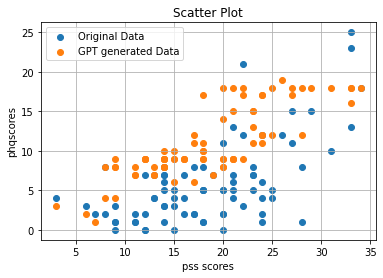

In [43]:
# Scatter Plot for real and GPT generated scores
import numpy as np
import matplotlib.pyplot as plt

x_data = np.array([point for point in scale_given_scores])
y_data = np.array([point for point in scale_generated_scores])
chat_gpt = np.array([point for point in chatgpt_scores])

plt.scatter(x_data, y_data, label='Original Data')
plt.scatter(x_data, chat_gpt, label='GPT generated Data')
plt.xlabel(scale_given + ' scores')
plt.ylabel(scale_generated + 'scores')
plt.title('Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()